# Welcome to HandsOn Week 14
In this HandsOn, we will try to implement one of machine learning method, which is polynomial regression. With this regression formula, $\textbf{a} = (\textbf{X}^T\textbf{X})^{-1}\textbf{X}^T\textbf{y}$ (see the slide for the detail), we need three type of operations, which are: (i) matrix transpose, (ii) matrix multiplication and (iii) matrix inversion. In this HandsOn, you only need to implement the matrix transpose and matrix multiplication parts in Spark RDD, and for the matrix inversion, we will skip this part and will use numpy libary (yes, numpy is not for distributed computing. The purpose of using numpy is merely for pedagogical purpose and to simplify this HandsOn. For real case in distributed system, you also need to implement the matrix inversion in distributed programming, e.g., [this method](https://dl.acm.org/doi/abs/10.1145/2600212.2600220) and [this method](https://arxiv.org/pdf/1801.04723.pdf).<br>

To give you a detailed flow of regression, a python implementation is given below. After that, you need to implement it in Spark RDD.

## Implementing Regression in Python
For learning purpose, a dummy dataset is used. The regression code implementation will be same for any data you use. The only difference is how to represent your data in "design matrix" $\textbf{X}$.

### Input-output data

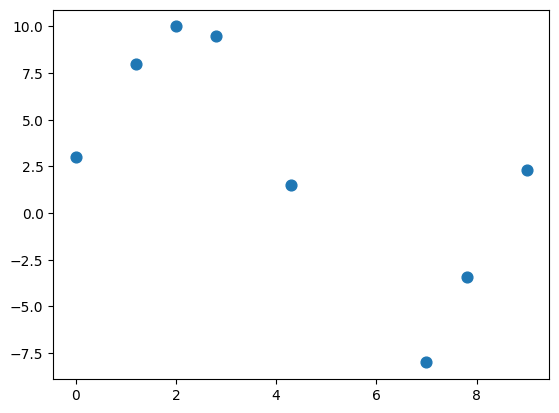

In [1]:
%matplotlib inline
import numpy as np
from numpy.linalg import inv
from matplotlib import pyplot as plt

# given input data x and label (output) data y for training
x = np.array([[0], [1.2], [2], [2.8], [4.3], [7], [7.8], [9]])
y = np.array(([[3], [8], [10], [9.5], [1.5], [-8], [-3.4], [2.3]]))

# given data below for testing
x_test = np.array([[5],[3]])
y_test = np.array([[0],[6]])

#plot training data for visualization purpose
plt.scatter(x.flatten(), y.flatten(), marker="o", label = "training data", s=60)
plt.show()

### Create matrix design $\textbf{X}$

In [5]:
# your polynomial order
order = 4

# arrange input data x to matrix design X (capital x)
def build_design_matrix(x, order):
    X = map(lambda x: np.asarray([x**i for i in range(0,order+1)]), x.flatten())
    X= np.asarray(list(X))
    return X
X = build_design_matrix(x, order)
np.set_printoptions(precision=2, suppress=True)
print(X)

[[   1.      0.      0.      0.      0.  ]
 [   1.      1.2     1.44    1.73    2.07]
 [   1.      2.      4.      8.     16.  ]
 [   1.      2.8     7.84   21.95   61.47]
 [   1.      4.3    18.49   79.51  341.88]
 [   1.      7.     49.    343.   2401.  ]
 [   1.      7.8    60.84  474.55 3701.51]
 [   1.      9.     81.    729.   6561.  ]]


### Calculate regression coefficient, $\textbf{a}$

In [6]:
# Let's breakdown into each operation

# calculate var1 = X^T.X,
# (matrix transpose & multiplication)
var1 = X.T.dot(X)

# calculate var2 = X^T.y,
# (matrix transpose & multiplication)
var2 = X.T.dot(y)

# do inversion
inv_result = inv(var1)

# calculate regression coefficient, a
# (matrix multiplication)
a = inv_result.dot(var2)
print("a:", a)
# here, we have (order+1) elements of matrix a

a: [[ 2.6 ]
 [ 9.09]
 [-3.26]
 [ 0.27]
 [-0.  ]]


### Calculate the prediction result of ```x_test```

In [7]:
# bring the x_test to design matrix
X_test = build_design_matrix(x_test, order)

# calculate the prediction (matrix multiplication operation)
prediction = X_test.dot(a)
print("Prediction:\n", prediction)

Prediction:
 [[-1.33]
 [ 7.56]]


### Plot the training data, testing data (with the prediction)

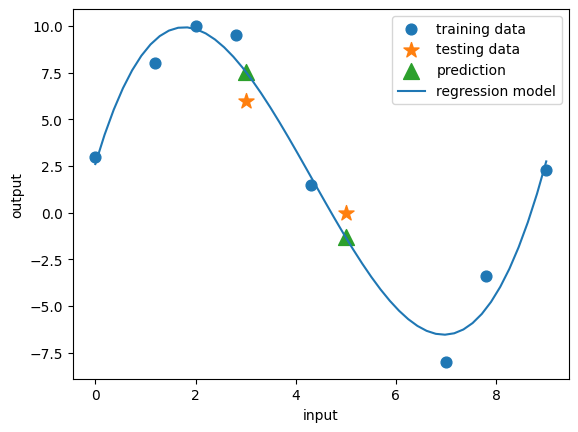

In [8]:
def plot_result(x, y, x_test, y_test, prediction, a, order):
    '''
    Function to plot the regression model
    Params:
        x, y = training data
        x_test, y_test = testing data
        prediction = prediction result of x_test using regression model (matrix a)
        a = regression model, which is the regression coefficients
        order = order of regression model
    '''
    # plot training data
    plt.scatter(x.flatten(), y.flatten(), marker="o", label = "training data", s=60)

    # plot testing data
    plt.scatter(x_test.flatten(), y_test.flatten(), marker="*", label = "testing data", s=130)

    # plot prediction result of testing data
    plt.scatter(x_test.flatten(), prediction.flatten(), marker="^", label = "prediction", s=130)

    # plot regression model
    x_axis = np.asarray(np.linspace(0,9,50)).reshape((-1,1))
    y_axis = build_design_matrix(x_axis, order).dot(a)
    plt.plot(x_axis.flatten(), y_axis.flatten(), label = "regression model")

    plt.xlabel("input")
    plt.ylabel("output")
    plt.legend()
    plt.show()

# call the plotting function 
plot_result(x, y, x_test, y_test, prediction, a, order)

Now your turn to implement regression in Spark RDD (again, only **for all matrix transpose & multiplication operations** and use numpy for the matrix inversion). Use the exactly same data above so that you will get a same plotting result if you correcty code in Spark RDD.

## Milestone 1
Make functions for matrix transpose and multiplication in Spark RDD

In [65]:
def matrix_transpose(matrix_input):
    '''
    Function to get a transposed matrix
    Param:
        matrix_input: RDD with 2 dimensions
    Return: transposed matrix of matrix_input
    '''
    # map to (row, index)
    a = matrix_input.zipWithIndex()

    # map to (row, (column, value))
    b = a.flatMap(lambda x: [(i, (x[1], x[0][i])) for i in range(len(x[0]))])

    # do groupByKey
    c = b.groupByKey().mapValues(list)

    # final formatting of the columns
    d = c.map(lambda x: [e[1] for e in x[1]])
    return d

def matrix_multiplication(matrix1, matrix2):
    '''
    Function to compute matrix multiplication in RDD
    Params:
        matrix1: RDD with 2 dimensions
        matrix2: RDD with 2 dimensions
    Return: multiplication result, in 2-D RDD
    '''
    rep1 = len(matrix2.collect()[0])
    rep2 = len(matrix1.collect())

    a1 = matrix1.zipWithIndex()
    a2 = matrix2.zipWithIndex()

    b1 = a1.flatMap(lambda x: [[[((x[1], col, i), x[0][i]) for col in range(rep1)]] for i in range(len(x[0]))])
    b1 = b1.flatMap(lambda x: x)
    b1 = b1.flatMap(lambda x: x)

    b2 = a2.flatMap(lambda x: [[[((row, i, x[1]), x[0][i]) for row in range(rep2)]] for i in range(len(x[0]))])
    b2 = b2.flatMap(lambda x: x)
    b2 = b2.flatMap(lambda x: x)

    tmp = b1.union(b2)
    tmp = tmp.reduceByKey(lambda x, y: x * y)
    tmp = tmp.map(lambda x: ((x[0][0], x[0][1]), x[1]))
    tmp = tmp.reduceByKey(lambda x, y: x + y).sortByKey().map(lambda x: (x[0][0], x[1]))
    tmp = tmp.groupByKey().mapValues(list)
    tmp = tmp.map(lambda x: x[1])

    return tmp

## Milestone 2
Calculate the regression coefficient, $\textbf{a}$, using ```matrix_transpose``` and ```matrix_multiplication``` functions you've made above, and use numpy for the matrix inversion.

In [ ]:
from pyspark import SparkContext
sc = SparkContext()

In [66]:
# for testing purposes:

pp = np.asarray([[1, 2, 3], [4, 5, 6]])
qq = np.asarray(([[7, 8], [9,10], [11, 12]]))

pp_rdd = sc.parallelize(pp)
qq_rdd = sc.parallelize(qq)

matrix_multiplication(pp_rdd, qq_rdd)

PythonRDD[296] at RDD at PythonRDD.scala:53

In [67]:
X_rdd = sc.parallelize(X)
y_rdd = sc.parallelize(y)

# calculate var1 = X^T.X,
# (matrix transpose & multiplication)
var_1 = matrix_multiplication(matrix_transpose(X_rdd), X_rdd)


# calculate var2 = X^T.y,
# (matrix transpose & multiplication)
var_2 = matrix_multiplication(matrix_transpose(X_rdd), y_rdd)

# do inversion
inv_var_1 = sc.parallelize(inv(var_1.collect()))

# calculate regression coefficient, a
# (matrix multiplication)
a_rdd = matrix_multiplication(inv_var_1, var_2)


## Milestone 3
Calculate the prediction result of ```x_test```

In [68]:
# write your code here (use matrix multiplication function you've made above)

X_test_rdd = sc.parallelize(X_test)
prediction_with_rdd = matrix_multiplication(X_test_rdd, a_rdd)
print("Prediction:\n", prediction_with_rdd.collect())

Prediction:
 [[-1.3337573973818322], [7.5570834485702445]]


## Milestone 4
Do plotting using ```plot_result``` function

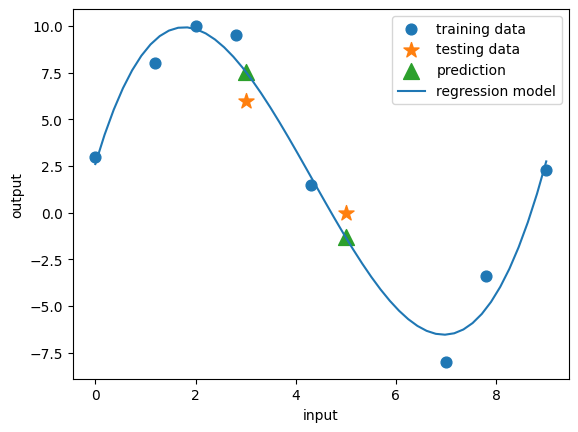

In [70]:
# write your code here (note: for plotting purpose, all the related data in RDD, 
# you can do "collect()" to obtain the corresponding local python collections -variables-
# so that you can use them as parameters in plot_result function)


plot_result(x, y, x_test, y_test, np.array(prediction_with_rdd.collect()), a_rdd.collect(), order)

# Submission
Submit this jupyter notebook to course portal with file naming format of: ```HandsOnWeek14_NIM_NamaLengkap.ipynb```. Make sure that when uploading this ipynb file, it has the output (not blank).